# Figure 4

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
# Scientific and datavis stack
import iris
import matplotlib.pyplot as plt

In [3]:
# My packages
from aeolus.calc import time_mean, vertical_mean
from aeolus.const import add_planet_conf_to_cubes, init_const
from aeolus.io import load_data
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator
from aeolus.subset import l_range_constr
from pouch.clim_diag import calc_derived_cubes
from pouch.plot import (
    KW_AUX_TTL,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    KW_ZERO_LINE,
    XLOCS,
    YLOCS,
    figsave,
    use_style,
)

In [4]:
# Local modules
import mypaths
from angular_momentum_budget import AngularMomentumBudget
from commons import GLM_SUITE_ID, SIM_LABELS

Apply custom matplotlib style sheet.

In [5]:
use_style()

## Load the data for the two key experiments

Define paths to input data and results.

In [6]:
img_prefix = f"{GLM_SUITE_ID}_spinup"
inp_dir = mypaths.sadir / f"{GLM_SUITE_ID}_spinup"
time_prof = "mean_days0_499"
plotdir = mypaths.plotdir / img_prefix

Load processed data.

In [7]:
# Load processed data
runs = {}
for sim_label, sim_prop in SIM_LABELS.items():
    planet = sim_prop["planet"]
    const = init_const(planet, directory=mypaths.constdir)
    cl = load_data(
        files=inp_dir / f"{GLM_SUITE_ID}_{sim_label}_{time_prof}.nc",
    )

    add_planet_conf_to_cubes(cl, const)
    # Derive additional fields
    calc_derived_cubes(cl, const=const, model=um)
    # Use the cube list to initialise an AtmoSim object
    runs[sim_label] = AngularMomentumBudget(
        cl,
        name=sim_label,
        planet=planet,
        const_dir=mypaths.constdir,
        timestep=cl[0].attributes["timestep"],
        model=um,
        vert_coord="z",
    )

Define time periods for averaging the terms.

In [8]:
periods = {
    "first": {"days": [0, 20], "lim_vprof": [-40, 40], "lim_yprof": [-5, 15]},
    "second": {"days": [20, 80], "lim_vprof": [-40, 40], "lim_yprof": [-17, 17]},
    "third": {"days": [80, 200], "lim_vprof": [-150, 150], "lim_yprof": [-50, 50]},
    "fourth": {"days": [250, 450], "lim_vprof": [-150, 150], "lim_yprof": [-50, 50]},
}

tm_suffix = "_".join("-".join(str(j) for j in i["days"]) for i in periods.values())

Define what terms to display and how to display them.

In [9]:
terms_to_show = AngularMomentumBudget.term_group_adv_labels

all_terms_opts = {
    "mean_adv": {"kw_plt": {"color": "tab:orange"}, "title": "Mean advection"},
    "stat": {"kw_plt": {"color": "tab:blue"}, "title": "Stationary eddy"},
    "trans": {"kw_plt": {"color": "tab:purple"}, "title": "Transient eddy"},
    "time_change": {
        "kw_plt": {"color": "k", "linestyle": "-"},
        "title": "Change of m with time",
    },
    "residual": {"kw_plt": {"color": "k", "linestyle": "--"}, "title": "Residual"},
}

Also define the labels for the figure file name.

In [10]:
main_key, aux_key = ["ang_mom_bud", "ang_mom_time_change"]
imgname = f"{img_prefix}__{'_'.join(SIM_LABELS.keys())}__{'_'.join([main_key, aux_key])}__{tm_suffix}__yprof"

Define the height (in km) over which to average the results.

In [11]:
h1 = 1.5
h2 = 20
height_constraint = l_range_constr(h1, h2)

Do the calculations for each of the diagnostics and store results in a separate dictionary.

In [12]:
RESULTS = {}

for sim_label in SIM_LABELS:
    RESULTS[sim_label] = {}
    for (period_key, period_prop) in periods.items():
        RESULTS[sim_label][period_key] = {}

        day_start, day_end = period_prop["days"]
        day_constr = iris.Constraint(
            **{um.fcst_prd: lambda x: day_start <= x.point / 24 <= day_end}
        )
        the_run = runs[sim_label].extract(day_constr)

        RESULTS[sim_label][period_key]["the_run"] = the_run
        # RESULTS[sim_label][period_key]["sigma_p"] = the_run.sigma_p_tsm
        reduce = lambda cube: vertical_mean(
            cube.extract(height_constraint),
            weight_by=time_mean(the_run.rho_zm.extract(height_constraint)),
        )

        term_sum = []
        for i, term_label in enumerate(terms_to_show):
            cube = reduce(the_run[term_label])
            RESULTS[sim_label][period_key][term_label] = cube
            term_sum.append(cube)

        RESULTS[sim_label][period_key]["time_change"] = reduce(the_run[aux_key])
        RESULTS[sim_label][period_key]["residual"] = (
            sum(term_sum) - RESULTS[sim_label][period_key]["time_change"]
        )

### Create a figure

In [13]:
kw_common = dict(linewidth=2)

ncols = len(SIM_LABELS)
nrows = len(periods)
fig = plt.figure(figsize=(ncols * 6, nrows * 3.5), constrained_layout=True)
axd = fig.subplot_mosaic(
    [
        [f"{sim_label}-{period_key}" for sim_label in SIM_LABELS]
        for period_key in periods
    ]
)

iletters = subplot_label_generator()
for ax in axd.values():
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)

for (sim_label, sim_prop) in SIM_LABELS.items():
    for (period_key, period_prop) in periods.items():
        ax = axd[f"{sim_label}-{period_key}"]
        if ax.get_subplotspec().is_first_row():
            ax.set_title(f"{sim_prop['title']}", **KW_MAIN_TTL)
        ax.axvline(**KW_ZERO_LINE)
        ax.axhline(**KW_ZERO_LINE)
        ax.set_xticks(YLOCS)
        ax.set_xlim(YLOCS[0], YLOCS[-1])
        # ax.set_ylim(period_prop.get("lim_yprof"))
        day_start, day_end = period_prop["days"]
        day_constr = iris.Constraint(
            **{um.fcst_prd: lambda x: day_start <= x.point / 24 <= day_end}
        )
        ax.set_title(f"{day_start}-{day_end} day mean", **KW_AUX_TTL)
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel("Latitude [$\degree$]")
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(f"[{AngularMomentumBudget.tex_units}]")
        for vrbl_key, vrbl_prop in all_terms_opts.items():
            cube = RESULTS[sim_label][period_key][vrbl_key]
            ax.plot(
                cube.coord(um.y).points,
                cube.data,
                **kw_common,
                **vrbl_prop["kw_plt"],
            )

add_custom_legend(
    fig,
    {vrbl_prop["title"]: vrbl_prop["kw_plt"] for vrbl_prop in all_terms_opts.values()},
    loc="upper center",
    bbox_to_anchor=(0.5, 1.1),
    frameon=False,
    ncol=2,
    title=f"Vertically averaged angular momentum (m) budget terms",
)

plt.close()

# Show the figure

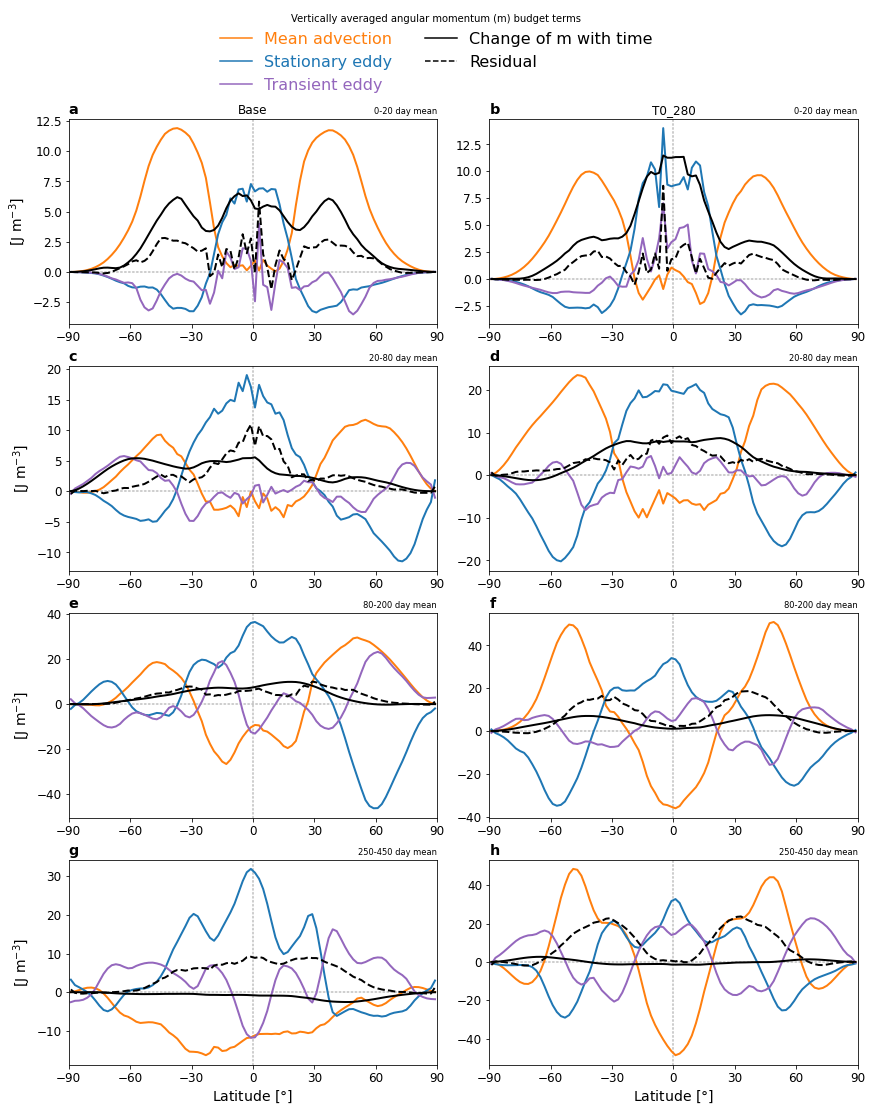

In [14]:
fig

* **Meridional profiles of the angular momentum budget terms ($J\,m^{-3}$) in Eq.~2 during the spin-up phase of the (left) _Base_ and (right) _T0\_280_ simulations: (orange) mean advection terms, (blue) stationary eddy terms, (purple) transient eddy terms.**
* **The dashed black line shows the residual.**
* **The terms are averaged within the troposphere ($\approx 1-20\,km$) and over the periods of (a, b) 0-20 days, (c, d) 20-80 days, (e, f) 80-200 days, and (g, h) 250-450 days.**
* **Note the jagged lines in the two top panels are due to a very short period of averaging (20 days).**

In [15]:
figsave(fig, plotdir / imgname)

Saved to ../plots/ch111_spinup/ch111_spinup__base_sens-t280k__ang_mom_bud_ang_mom_time_change__0-20_20-80_80-200_250-450__yprof.png
